Evaluating all queries:   0%|          | 0/50 [00:00<?, ?it/s]


Query ID: 1
Query: teacher get tenure user heard country give teacher tenure others dont interested reason tenure user search positive negative argument situation school teacher university professor interest highly relevant argument make clear statement tenure teacher school university relevant argument consider tenure generally specifically teacher instead talk tenure consider situation teacher financial independence
Relevant docs: 23
   Precision@1000: 0.0170
   Recall@1000: 0.7391
   AP: 0.5902
   NDCG@1000: 0.7499
   Top 5 Retrieved: ['Sc065954f-A6deb09b6', 'S51530f3f-A6ac2dcba', 'S51530f3f-Ac5b10bae', 'S51530f3f-Ae32a4a1b', 'Sb0680508-A304d661e']
   Relevant Retrieved: ['Sc065954f-A6deb09b6', 'S51530f3f-Ae32a4a1b', 'Sb0680508-A304d661e']

Query ID: 2
Query: vaping ecigarettes safe consider switch smoking vaping user wonder extent vaping safer new risk may involve compare smoking risk clear vaping market benefit raise doubt highly relevant argument support deny safety vaping give 

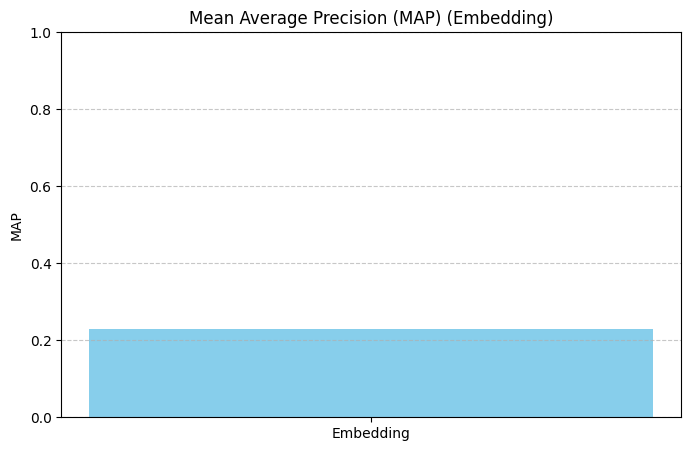

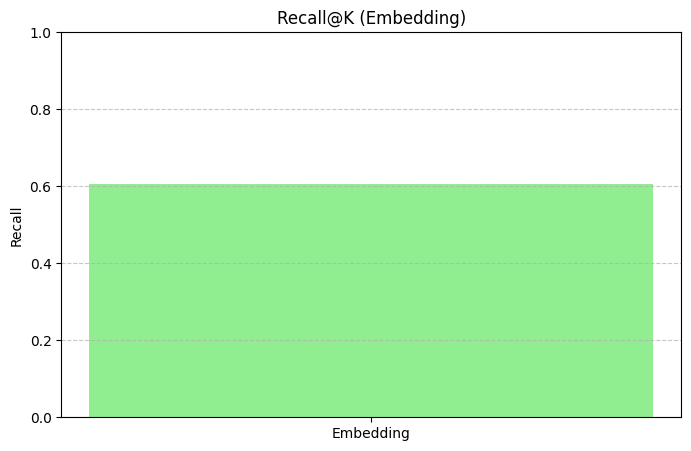

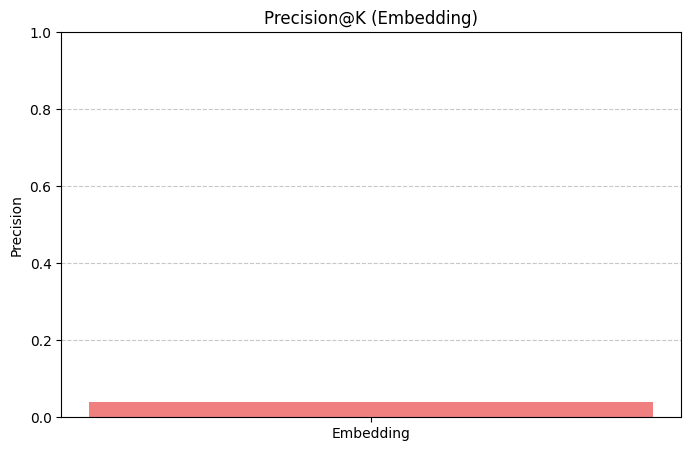

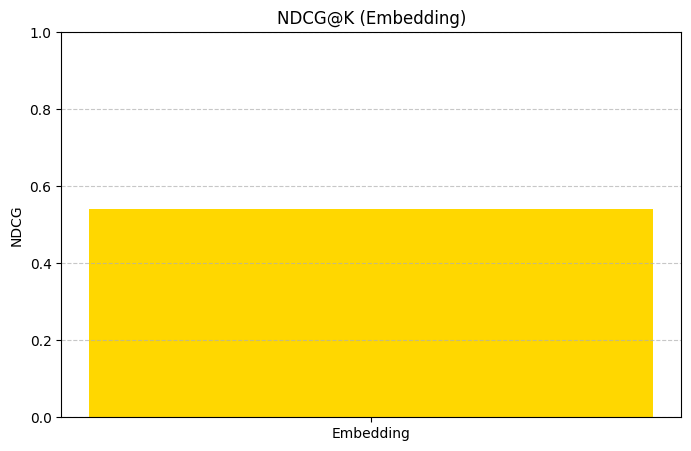


All queries evaluated successfully!


In [1]:
import requests
import csv
from collections import defaultdict
from tqdm.notebook import tqdm
from sklearn.metrics import average_precision_score, ndcg_score
import numpy as np
import matplotlib.pyplot as plt

EMBEDDING_URL = "http://localhost:8004/search"
DATASET = "argsme"
TOP_K = 1000

def load_queries(path, num_queries=None):
    queries = []
    with open(path, encoding="utf-8") as f:
        reader = csv.DictReader(f, delimiter="\t")
        for row in reader:
            queries.append({"query_id": row["query_id"], "query": row["processed_text"]})
            if num_queries and len(queries) >= num_queries:
                break
    return queries

def load_qrels(path):
    qrels = defaultdict(dict)
    with open(path, encoding="utf-8") as f:
        next(f)
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) < 3:
                continue
            qid, docid, rel = parts[:3]
            qrels[qid][docid] = int(rel)
    return qrels

def search_embedding(query, dataset=DATASET, top_k=TOP_K):
    payload = {
        "dataset": dataset,
        "query": query,
        "top_k": top_k,
        "use_faiss": True
    }
    response = requests.post(EMBEDDING_URL, json=payload)
    response.raise_for_status()
    response_data = response.json()
    results = response_data["results"]
    return results

def compute_metrics(gt, pred_docs, pred_scores, top_k):
    hits = np.array([1 if doc in gt else 0 for doc in pred_docs])
    true_rels = np.array([gt.get(doc, 0) for doc in pred_docs])
    ap = average_precision_score(hits, pred_scores) if hits.sum() > 0 else 0.0
    precision = hits.sum() / top_k
    recall = hits.sum() / len(gt) if len(gt) > 0 else 0.0
    ndcg = ndcg_score([true_rels], [pred_scores]) if true_rels.sum() > 0 else 0.0
    return ap, precision, recall, ndcg

queries_path = r"D:\5th year\IR\Final_project_IR\data\vectors\argsme\processed\ARGSME_cleaned_queries.tsv"
qrels_path = r"D:\5th year\IR\Final_project_IR\data\vectors\argsme\qrels.tsv"

queries = load_queries(queries_path)
qrels = load_qrels(qrels_path)

metrics = {"AP": [], "Recall": [], "Precision": [], "NDCG": []}
failed_queries = []

for q in tqdm(queries, desc="Evaluating all queries"):
    qid = q["query_id"]
    query_text = q["query"]
    gt = qrels.get(qid, {})

    print(f"\nQuery ID: {qid}")
    print(f"Query: {query_text}")
    print(f"Relevant docs: {len(gt)}")

    try:
        results = search_embedding(query_text)
        pred_docs = [str(r[0]) for r in results[:TOP_K]]
        pred_scores = [r[1] for r in results[:TOP_K]]
        ap, precision, recall, ndcg = compute_metrics(gt, pred_docs, pred_scores, TOP_K)

        metrics["AP"].append(ap)
        metrics["Recall"].append(recall)
        metrics["Precision"].append(precision)
        metrics["NDCG"].append(ndcg)

        print(f"   Precision@{TOP_K}: {precision:.4f}")
        print(f"   Recall@{TOP_K}: {recall:.4f}")
        print(f"   AP: {ap:.4f}")
        print(f"   NDCG@{TOP_K}: {ndcg:.4f}")
        print(f"   Top 5 Retrieved: {pred_docs[:5]}")
        print(f"   Relevant Retrieved: {[doc for doc in pred_docs[:5] if doc in gt]}")

    except Exception as e:
        print(f"Error in query_id={qid}: {e}")
        metrics["AP"].append(0)
        metrics["Recall"].append(0)
        metrics["Precision"].append(0)
        metrics["NDCG"].append(0)
        failed_queries.append(qid)

def plot_metric(metric_values, metric_name, ylabel, color):
    plt.figure(figsize=(8, 5))
    plt.bar(["Embedding"], [metric_values], color=color)
    plt.title(f"{metric_name} (Embedding)")
    plt.ylabel(ylabel)
    plt.ylim(0, 1)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

avg_ap = np.mean(metrics["AP"])
avg_recall = np.mean(metrics["Recall"])
avg_precision = np.mean(metrics["Precision"])
avg_ndcg = np.mean(metrics["NDCG"])

print("\n=== FINAL AVERAGE RESULTS ===")
print(f"MAP: {avg_ap:.4f}")
print(f"Recall@k: {avg_recall:.4f}")
print(f"Precision@k: {avg_precision:.4f}")
print(f"NDCG@k: {avg_ndcg:.4f}")

plot_metric(avg_ap, "Mean Average Precision (MAP)", "MAP", "skyblue")
plot_metric(avg_recall, "Recall@K", "Recall", "lightgreen")
plot_metric(avg_precision, "Precision@K", "Precision", "lightcoral")
plot_metric(avg_ndcg, "NDCG@K", "NDCG", "gold")

if failed_queries:
    print(f"\nFailed queries: {failed_queries}")
else:
    print("\nAll queries evaluated successfully!")

Evaluating all queries:   0%|          | 0/1444 [00:00<?, ?it/s]


Query ID: 123839
Query: yanni
Relevant docs: 6
   Precision@1000: 0.0030
   Recall@1000: 0.5000
   AP: 0.2074
   NDCG@1000: 0.5178
   Top 5 Retrieved: ['2129172', '123839', '1709594', '2293779', '1076430']
   Relevant Retrieved: ['123839']

Query ID: 188629
Query: k pop
Relevant docs: 6
   Precision@1000: 0.0060
   Recall@1000: 1.0000
   AP: 0.1148
   NDCG@1000: 0.4660
   Top 5 Retrieved: ['251586', '188629', '2360963', '2137048', '1274659']
   Relevant Retrieved: ['188629']

Query ID: 13898
Query: venice film festival
Relevant docs: 6
   Precision@1000: 0.0040
   Recall@1000: 0.6667
   AP: 0.3388
   NDCG@1000: 0.7435
   Top 5 Retrieved: ['13898', '1382760', '941146', '1698181', '1783344']
   Relevant Retrieved: ['13898']

Query ID: 316959
Query: downtown brooklyn
Relevant docs: 9
   Precision@1000: 0.0070
   Recall@1000: 0.7778
   AP: 0.2280
   NDCG@1000: 0.6683
   Top 5 Retrieved: ['316959', '2156815', '1013240', '2046262', '1469362']
   Relevant Retrieved: ['316959']

Query ID: 515

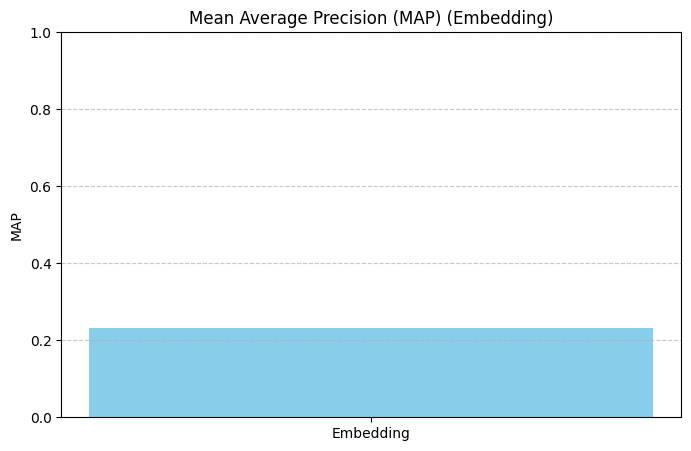

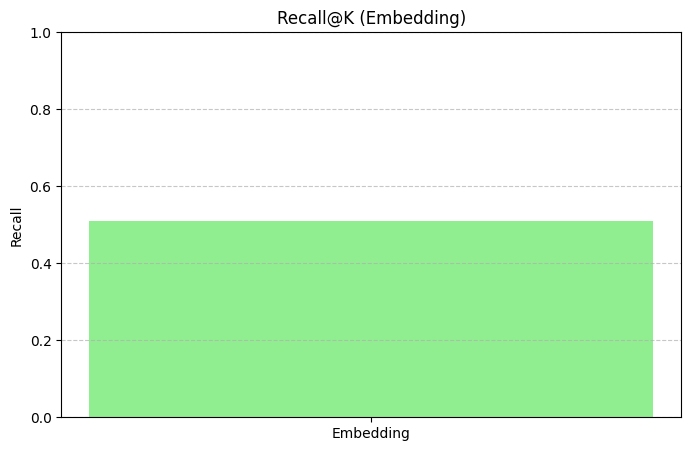

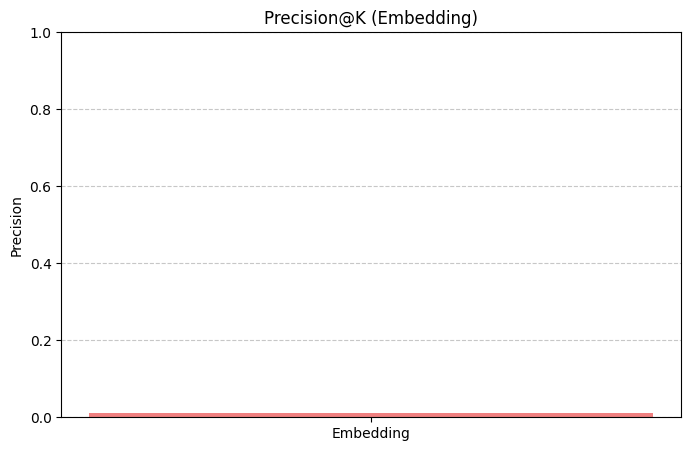

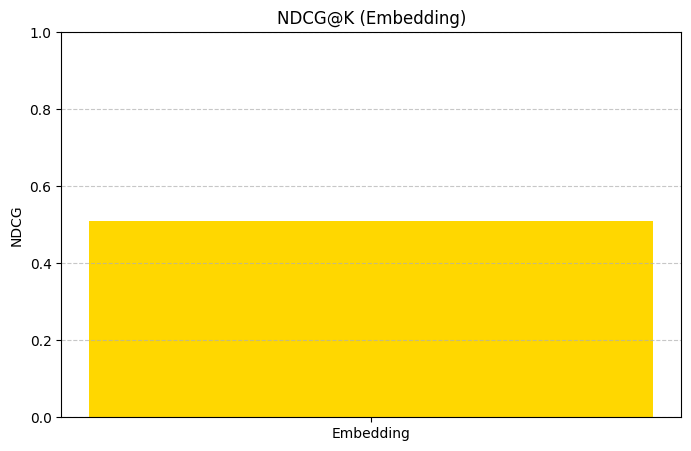


All queries evaluated successfully!


In [1]:
import requests
import csv
from collections import defaultdict
from tqdm.notebook import tqdm
from sklearn.metrics import average_precision_score, ndcg_score
import numpy as np
import matplotlib.pyplot as plt

EMBEDDING_URL = "http://localhost:8004/search"
DATASET = "wikir"
TOP_K = 1000

def load_queries(path, num_queries=None):
    queries = []
    with open(path, encoding="utf-8") as f:
        reader = csv.DictReader(f, delimiter="\t")
        for row in reader:
            queries.append({"query_id": row["query_id"], "query": row["text"]})
            if num_queries and len(queries) >= num_queries:
                break
    return queries

def load_qrels(path):
    qrels = defaultdict(dict)
    with open(path, encoding="utf-8") as f:
        reader = csv.DictReader(f, delimiter="\t")
        for row in reader:
            qid = row["query_id"]
            docid = row["doc_id"]
            rel = int(row["relevance"])
            qrels[qid][docid] = rel
    return qrels

def search_embedding(query, dataset=DATASET, top_k=TOP_K):
    payload = {
        "dataset": dataset,
        "query": query,
        "top_k": top_k,
        "use_faiss": True
    }
    response = requests.post(EMBEDDING_URL, json=payload)
    response.raise_for_status()
    response_data = response.json()
    results = response_data["results"]
    return results

def compute_metrics(gt, pred_docs, pred_scores, top_k):
    hits = np.array([1 if doc in gt else 0 for doc in pred_docs])
    true_rels = np.array([gt.get(doc, 0) for doc in pred_docs])
    ap = average_precision_score(hits, pred_scores) if hits.sum() > 0 else 0.0
    precision = hits.sum() / top_k
    recall = hits.sum() / len(gt) if len(gt) > 0 else 0.0
    ndcg = ndcg_score([true_rels], [pred_scores]) if true_rels.sum() > 0 else 0.0
    return ap, precision, recall, ndcg

queries_path = r"D:\5th year\IR\Final_project_IR\data\vectors\wikir\processed\queries_cleaned.tsv"
qrels_path = r"D:\5th year\IR\Final_project_IR\data\vectors\wikir\qrels.tsv"

queries = load_queries(queries_path)
qrels = load_qrels(qrels_path)

metrics = {"AP": [], "Recall": [], "Precision": [], "NDCG": []}
failed_queries = []

for q in tqdm(queries, desc="Evaluating all queries"):
    qid = q["query_id"]
    query_text = q["query"]
    gt = qrels.get(qid, {})

    print(f"\nQuery ID: {qid}")
    print(f"Query: {query_text}")
    print(f"Relevant docs: {len(gt)}")

    try:
        results = search_embedding(query_text)
        pred_docs = [str(r[0]) for r in results[:TOP_K]]
        pred_scores = [r[1] for r in results[:TOP_K]]
        ap, precision, recall, ndcg = compute_metrics(gt, pred_docs, pred_scores, TOP_K)

        metrics["AP"].append(ap)
        metrics["Recall"].append(recall)
        metrics["Precision"].append(precision)
        metrics["NDCG"].append(ndcg)

        print(f"   Precision@{TOP_K}: {precision:.4f}")
        print(f"   Recall@{TOP_K}: {recall:.4f}")
        print(f"   AP: {ap:.4f}")
        print(f"   NDCG@{TOP_K}: {ndcg:.4f}")
        print(f"   Top 5 Retrieved: {pred_docs[:5]}")
        print(f"   Relevant Retrieved: {[doc for doc in pred_docs[:5] if doc in gt]}")

    except Exception as e:
        print(f"Error in query_id={qid}: {e}")
        metrics["AP"].append(0)
        metrics["Recall"].append(0)
        metrics["Precision"].append(0)
        metrics["NDCG"].append(0)
        failed_queries.append(qid)

def plot_metric(metric_values, metric_name, ylabel, color):
    plt.figure(figsize=(8, 5))
    plt.bar(["Embedding"], [metric_values], color=color)
    plt.title(f"{metric_name} (Embedding)")
    plt.ylabel(ylabel)
    plt.ylim(0, 1)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

avg_ap = np.mean(metrics["AP"])
avg_recall = np.mean(metrics["Recall"])
avg_precision = np.mean(metrics["Precision"])
avg_ndcg = np.mean(metrics["NDCG"])

print("\n=== FINAL AVERAGE RESULTS ===")
print(f"MAP: {avg_ap:.4f}")
print(f"Recall@k: {avg_recall:.4f}")
print(f"Precision@k: {avg_precision:.4f}")
print(f"NDCG@k: {avg_ndcg:.4f}")

plot_metric(avg_ap, "Mean Average Precision (MAP)", "MAP", "skyblue")
plot_metric(avg_recall, "Recall@K", "Recall", "lightgreen")
plot_metric(avg_precision, "Precision@K", "Precision", "lightcoral")
plot_metric(avg_ndcg, "NDCG@K", "NDCG", "gold")

if failed_queries:
    print(f"\nFailed queries: {failed_queries}")
else:
    print("\nAll queries evaluated successfully!")

In [2]:
def verify_scores_sorted(results, query_id):
    """
    Check if scores are sorted in descending order.
    """
    scores = [r[1] for r in results]
    for i in range(len(scores) - 1):
        if scores[i] < scores[i + 1]:
            print(f"⚠️ Warning: Scores are not sorted for query_id={query_id}")
            return False
    print(f"✅ Scores are properly sorted for query_id={query_id}")
    return True


In [7]:
# ====== New Check Block ======

def normalize_doc_id(doc_id):
    """
    Cleans the doc_id to match qrels format:
    - Removes 'argsme_doc_' prefix.
    - Trims anything after '__' (e.g., '__PREMISE__41').
    """
    if doc_id.startswith("argsme_doc_"):
        doc_id = doc_id.replace("argsme_doc_", "")
    if "__" in doc_id:
        doc_id = doc_id.split("__")[0]
    return doc_id


for q in tqdm(queries, desc="Checking API response and relevance"):
    qid = q["query_id"]
    query_text = q["query"]
    gt = qrels.get(qid, {})

    print(f"\n🔍 Query ID: {qid}")
    print(f"Query: {query_text}")
    print(f"Relevant docs in qrels: {len(gt)}")

    try:
        # Get API results
        results = search_embedding(query_text)
        
        # Normalize and sort results manually
        sorted_results = sorted(results, key=lambda x: x[1], reverse=True)
        pred_docs = [normalize_doc_id(r[0]) for r in sorted_results[:TOP_K]]
        pred_scores = [r[1] for r in sorted_results[:TOP_K]]

        # Check if scores are sorted
        is_sorted = all(pred_scores[i] >= pred_scores[i+1] for i in range(len(pred_scores)-1))
        if is_sorted:
            print(f"✅ Scores are properly sorted for query_id={qid}")
        else:
            print(f"⚠️ Scores are not sorted for query_id={qid}")

        # Check for overlap between predicted docs and relevant docs
        relevant_retrieved = [doc for doc in pred_docs if doc in gt]
        if relevant_retrieved:
            print(f"✅ Found {len(relevant_retrieved)} relevant docs for query_id={qid}")
        else:
            print(f"⚠️ No relevant documents retrieved for query_id={qid}")

        # Show top results
        print(f"Top 5 Retrieved (cleaned): {pred_docs[:5]}")
        print(f"Relevant Retrieved: {relevant_retrieved[:5]}")

    except Exception as e:
        print(f"❌ Error in query_id={qid}: {e}")


Checking API response and relevance:   0%|          | 0/50 [00:00<?, ?it/s]


🔍 Query ID: 1
Query: teacher get tenure user heard country give teacher tenure others dont interested reason tenure user search positive negative argument situation school teacher university professor interest highly relevant argument make clear statement tenure teacher school university relevant argument consider tenure generally specifically teacher instead talk tenure consider situation teacher financial independence
Relevant docs in qrels: 23
✅ Scores are properly sorted for query_id=1
⚠️ No relevant documents retrieved for query_id=1
Top 5 Retrieved (cleaned): ['91478', '502', '119817', '125578', '337267']
Relevant Retrieved: []

🔍 Query ID: 2
Query: vaping ecigarettes safe consider switch smoking vaping user wonder extent vaping safer new risk may involve compare smoking risk clear vaping market benefit raise doubt highly relevant argument support deny safety vaping give valid reason relevant argument argue vaping instead safety vaping comparison smoking respect health effect dr